In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', '..')))

In [2]:
import torch
from QCCL.dataset import GraphDataset
from QCCL.Models import GCNFeatureExtractor
from QCCL.utils.train import train
import random
import numpy as np


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\melan\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\melan\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\melan\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", 

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

In [4]:
set_seed(42)
use_pre_paired = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pooling = 'global_avg'
patience = 25
alpha = 0.05

embedding_size = 1024

num_augmented_views = 3

# tuned hypeparameters
epochs = 1000
n_layers = 5
projection_size = 512
temperature = 0.01
batch_size = 8
learning_rate = 0.01

In [5]:
from QCCL.dataset import load_data
X = load_data(file_name='dataset_90.pkl')

Loaded 90 QuantumCircuitGraph objects.


In [6]:
# test_mask = torch.zeros(len(X), dtype=torch.bool)
# test_mask[-3:] = True
# val_mask = torch.zeros(len(X), dtype=torch.bool)
# val_mask[-6:-3] = True

# train_data = [X[i] for i in range(len(X)) if not test_mask[i] and not val_mask[i]]
# val_data = [X[i] for i in range(len(X)) if val_mask[i]]
# test_data = [X[i] for i in range(len(X)) if test_mask[i]]

# # train_data, val_data = train_test_split(train_data, train_size=0.8, shuffle=True)
# print('Data split:')
# print('train:', len(train_data), '(', round((len(train_data) / len(X)) * 100, 1), '%)')
# print('val:', len(val_data), '(', round((len(val_data) / len(X)) * 100, 1), '%)')
# print('test:', len(test_data), '(', round((len(test_data) / len(X)) * 100, 1), '%)')

# train_val_dataset = GraphDataset(train_data+val_data, pre_paired=use_pre_paired)
# test_dataset = GraphDataset(test_data, pre_paired=use_pre_paired)

In [7]:
from QCCL.dataset import GraphDataset
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(X, train_size=0.6, shuffle=True)
val_data, test_data = train_test_split(test_data, train_size=0.5, shuffle=True)

train_dataset = GraphDataset(train_data, pre_paired=use_pre_paired)
val_dataset = GraphDataset(val_data, pre_paired=use_pre_paired)
test_dataset = GraphDataset(test_data, pre_paired=use_pre_paired)

In [8]:
train_dataset

In [9]:
print('Data split:')
print('train:', len(train_data), '(', round((len(train_data) / len(X)) * 100, 1), '%)')
print('val:', len(val_data), '(', round((len(val_data) / len(X)) * 100, 1), '%)')
print('test:', len(test_data), '(', round((len(test_data) / len(X)) * 100, 1), '%)')

Data split:
train: 54 ( 60.0 %)
val: 18 ( 20.0 %)
test: 18 ( 20.0 %)


In [10]:
train_dataset[0]

(Data(x=[406, 6], edge_index=[2, 638]), Data(x=[406, 6], edge_index=[2, 640]))

In [11]:
n_features = train_dataset[0][0].x.size(1)
print(f"number of features in the dataset: {n_features}")

number of features in the dataset: 6


In [12]:
from QCCL.Models import build_model

model = build_model(n_features, 
                    embedding_size, 
                    model_type='simclr', 
                    num_layers=n_layers, 
                    proj_output_size=projection_size, 
                    global_node=True,
                    device=device)



Building model with 5 GCNConv layers and projection size 512...
SimCLR model built successfully.


In [13]:
history = train(model, 
                train_dataset,
                val_dataset, 
                epochs=2, 
                batch_size=batch_size, 
                lr=learning_rate, 
                tau=temperature, 
                device=device, 
                patience=patience,
                ema_alpha=alpha,
                verbose=False
                )

Starting training...


Training:  50%|█████     | 1/2 [00:17<00:14, 14.05s/epoch, loss=nan, val_loss=nan, ema_val_loss=nan]

Skipping transformation 'remove_identity' due to error: No matching subgraphs found for the given pattern.


Training: 100%|██████████| 2/2 [00:35<00:00, 17.78s/epoch, loss=nan]                                


KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

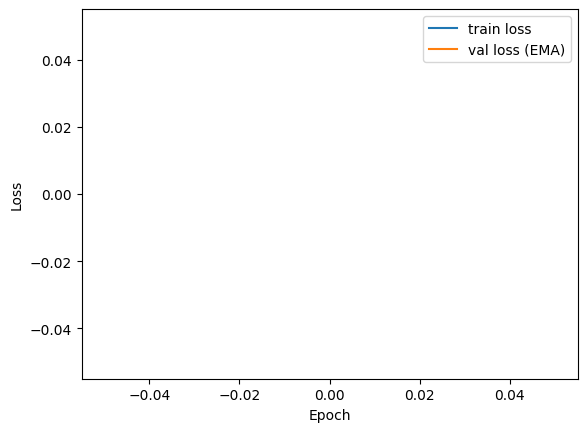

In [14]:
# plot loss trend during training
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['ema_val_loss'], label='val loss (EMA)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [15]:
# save model
torch.save(model.state_dict(), 'simclr_model.pth')

In [16]:
# create labels

from QCCL.utils.HyperparamTuner import prepare_test_data

labels, lin_eval_data, lin_eval_circuits = prepare_test_data(test_dataset, use_pre_paired, num_augmented_views, return_circuits=True)
print(f"In test set there are {len(labels)} samples, distributed in {len(test_data)} classes as follows: {labels}")

Building 3 augmented views for each sample in test set...
In test set there are 72 samples, distributed in 18 classes as follows: [ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11
 12 12 12 12 13 13 13 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17]


In [18]:
# split in train and test
from sklearn.model_selection import train_test_split
import numpy as np

split_mask = np.arange(len(lin_eval_data))
train_mask, test_mask = train_test_split(split_mask, train_size=0.7, stratify=labels)
train = [lin_eval_data[i] for i in train_mask]
test =  [lin_eval_data[i] for i in test_mask]
y_train = [int(labels[i]) for i in train_mask]
y_test = [int(labels[i]) for i in test_mask]

print(f"Train labels: {y_train}")
print(f"Test labels: {y_test}")

Train labels: [11, 7, 5, 3, 17, 8, 8, 10, 2, 12, 10, 5, 16, 15, 6, 17, 15, 15, 9, 9, 0, 14, 5, 6, 10, 9, 14, 13, 13, 12, 2, 1, 3, 4, 16, 11, 8, 7, 1, 6, 7, 12, 14, 3, 11, 13, 1, 4, 17, 0]
Test labels: [4, 6, 16, 13, 15, 11, 5, 2, 1, 14, 8, 0, 2, 0, 12, 7, 4, 9, 16, 3, 10, 17]


In [19]:
# Get embeddings
gnn = model.get_gnn().to(device)
train = torch.cat([gnn(d.to(device)) for d in train])
test = torch.cat([gnn(d.to(device)) for d in test])

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Scale embeddings
scaler = StandardScaler()
train = scaler.fit_transform(train.cpu().detach().numpy())
test = scaler.transform(test.cpu().detach().numpy())

print("Logistic Regression (multinomial) classifier:")
classifier = LogisticRegression(multi_class='multinomial').fit(train, y_train)
y_pred = classifier.predict(test)
y_pred_probs = classifier.predict_proba(test)
print(f"\tProbability of each class:\n\t {y_pred_probs}")
print(f"\tAccuracy of the classifier: {accuracy_score(y_test, y_pred)}")

print("Ground truth labels:")   
print(y_test)

print("Ground truth probabilities:")
# same size of y_pred_probs
y_probs = np.zeros(y_pred_probs.shape)
for i, y in enumerate(y_test):
    y_probs[i, int(y)] = 1
print(y_probs)

RuntimeError: Numpy is not available

In [ ]:
test_circuits = [qcg.quantum_circuit for qcg in test_data]
test_test_circuits = [test_circuits[i] for i in test_mask]

In [ ]:
from qiskit.converters import circuit_to_dag
from qiskit.transpiler.passes import RemoveBarriers 

# get number of qubits of circuits in the test set
print("Linear Evaluation dataset:")
print("Number of circuits:", len(test_circuits))
print("Number of equivalent circuits for every sample:", (num_augmented_views+1))
print("\n")

n_qubits_lin_eval = [c.num_qubits for c in test_circuits]
print("Number of qubits:", n_qubits_lin_eval)
# max_qubits_per_cc = [max(c.num_qubits for c in cc) for cc in test_test_circuits]
# print("Max number of qubits for each equivalent circuit set:", max_qubits_per_cc)
print("\n")

n_gates_lin_eval = [len(c.data) for c in test_circuits]
print("Number of gates:", n_gates_lin_eval)
print("\n")

remove_barriers = RemoveBarriers()
dags_lin_eval = [circuit_to_dag(remove_barriers(c)) for c in test_circuits]
depth_lin_eval = [len(list(dag.multigraph_layers())[1:-1]) for dag in dags_lin_eval]
print("Depth:", depth_lin_eval)
print("\n")

n_qubits_test = [n_qubits_lin_eval[i] for i in test_mask]
print("Number of qubits in the test split:", n_qubits_test)
n_gates_test = [n_gates_lin_eval[i] for i in test_mask]
print("Number of gates in the test split:", n_gates_test)
depth_test = [depth_lin_eval[i] for i in test_mask]
print("Depth in the test split:", depth_test)


# also number of gates/depth

In [79]:
# compute brier score for each sample

def brier_score(true_probs, pred_probs):
    return np.sum((true_probs - pred_probs)**2)

brier_scores = [brier_score(y_probs[i], y_pred_probs[i]) for i in range(len(y_probs))]

In [ ]:
print("Brier scores for each sample in the test set:", brier_scores)

In [ ]:
# plot brier scores against number of qubits
plt.scatter(n_qubits_test, brier_scores)
plt.xlabel('Number of qubits')
plt.ylabel('Brier score')
plt.show()

In [ ]:
# plot brier scores against number of gates
plt.scatter(n_gates_test, brier_scores)
plt.xlabel('Number of gates')
plt.ylabel('Brier score')
plt.show()

In [ ]:
# plot brier scores against depth
plt.scatter(depth_test, brier_scores)
plt.xlabel('Depth')
plt.ylabel('Brier score')
plt.show()

In [ ]:
# plot brier scores against product of number of qubits, depth and number of gates
plt.scatter(np.array(n_qubits_test)*np.array(depth_test)*np.array(n_gates_test), brier_scores)
plt.xlabel('Qubits x Depth x Gates')
plt.ylabel('Brier score')
plt.show()